# **Fairness Analysis on Bank Marketing Dataset**

## **1. Context**
The dataset originates from a Portuguese bank's marketing campaign that aimed to predict whether a client would subscribe to a term deposit. It was collected from phone calls made to clients, recording various attributes such as age, job, education, and response to previous campaigns.

- **Goal:** Predict the likelihood of a client subscribing to a term deposit.
- **Source:** UCI Machine Learning Repository.
- **Size:** 41,188 instances with 20 features and 1 target variable (`y`).

## **2. Exploratory Data Analysis**
We analyze the distribution of the target variable, and explore subscription rates across age groups and job types.


In [ ]:
# Load Data and Inspect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv("bank-additional/bank-additional-full.csv", sep=";")

# Display dataset structure
print("\n🟢 Dataset Information:\n")
df.info()

# Show first few rows
print("\n🟢 First 5 Rows:\n")
print(df.head())

# Dataset shape
print("\n🟢 Dataset Shape:", df.shape)

# Check for missing values
print("\n🟢 Missing Values in Each Column:\n")
print(df.isnull().sum())

# Display basic statistics (only for numeric columns)
print("\n🟢 Summary Statistics:\n")
print(df.describe())



🟢 Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.c

## **2.1 Target Variable Distribution**
We examine the proportion of clients who subscribed (`yes`) versus those who didn't (`no`).


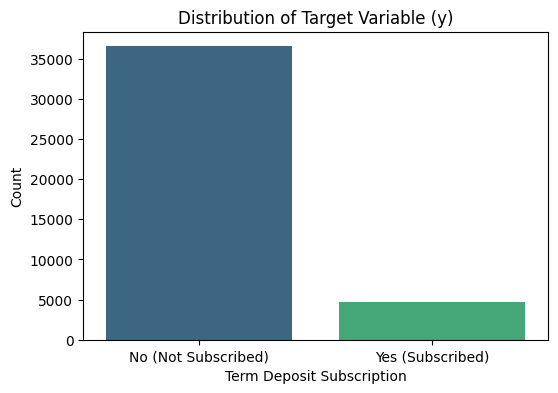


🔹 Subscription Rate: 11.27% (Proportion of 'Yes')



In [38]:
# Convert target variable to binary (0 = No, 1 = Yes)
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Plot target variable distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df['y'], palette='viridis')
plt.xticks([0,1], ['No (Not Subscribed)', 'Yes (Subscribed)'])
plt.xlabel("Term Deposit Subscription")
plt.ylabel("Count")
plt.title("Distribution of Target Variable (y)")
plt.show()

# Print subscription rates
subscription_rate = df['y'].mean()
print(f"\n🔹 Subscription Rate: {subscription_rate:.2%} (Proportion of 'Yes')\n")


The dataset is highly imbalanced, with only 11.27% of clients subscribing to a term deposit.

## **2.2 Subscription Rate by Age Group and Job Type**
We analyze how subscription rates vary across **age groups** and **job types**, which are relevant for fairness considerations.


In [ ]:
# Create Age Groups
df['age_group'] = pd.cut(df['age'], bins=[18, 30, 60, 100], labels=['Young', 'Middle-aged', 'Older'])


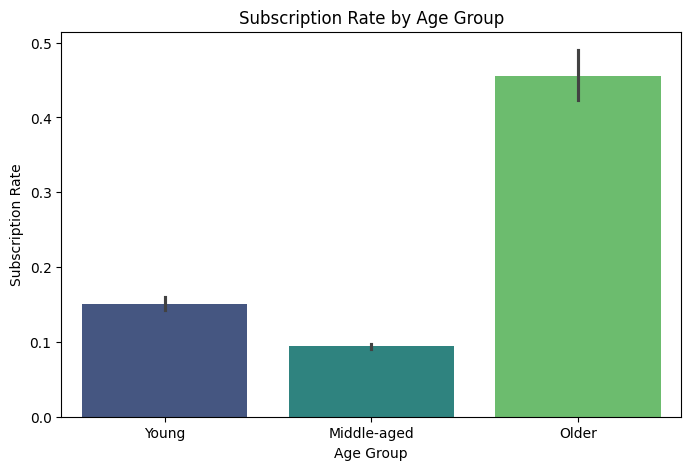

In [ ]:
# Subscription Rate by Age Group
plt.figure(figsize=(8,5))
sns.barplot(x=df['age_group'], y=df['y'], palette='viridis')
plt.xlabel("Age Group")
plt.ylabel("Subscription Rate")
plt.title("Subscription Rate by Age Group")
plt.show()


Older clients have a significantly higher subscription rate compared to younger and middle-aged groups.

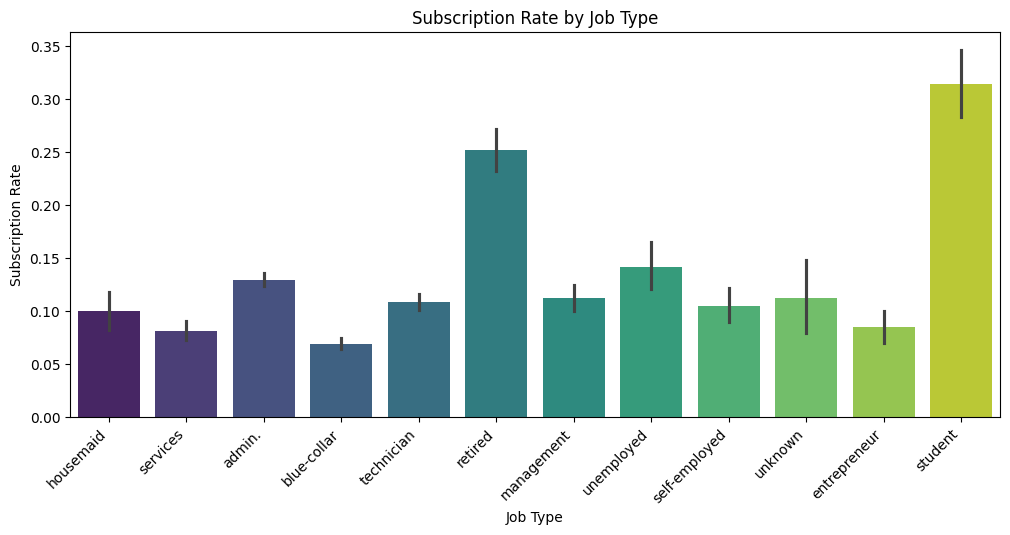

In [42]:
# Subscription Rate by Job Type
plt.figure(figsize=(12,5))
sns.barplot(x=df['job'], y=df['y'], palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Job Type")
plt.ylabel("Subscription Rate")
plt.title("Subscription Rate by Job Type")
plt.show()



Students and retired individuals have the highest subscription rates.

## **3.1 Fairness Analysis (Age as Sensitive Attribute)**
We train a **Random Forest Classifier** and compute fairness metrics:
- **Demographic Parity Difference**: Checks if positive predictions are fairly distributed.
- **Equal Opportunity Difference**: Ensures fairness in recall rates.


In [43]:
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                    'contact', 'month', 'day_of_week', 'poutcome']

for col in categorical_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

X = df_encoded.drop(columns=['y', 'age_group'])
y = df_encoded['y']
Z = df['age_group'].map({'Young': 0, 'Middle-aged': 1, 'Older': 2})

X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.2, random_state=42, stratify=y)


In [44]:
# Train Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

model = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=0, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(classification_report(y_test, y_pred))


Accuracy: 0.8587
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      7310
           1       0.44      0.95      0.60       928

    accuracy                           0.86      8238
   macro avg       0.72      0.90      0.76      8238
weighted avg       0.93      0.86      0.88      8238



In [45]:
# Compute Fairness Metrics
import numpy as np

def compute_group_rates(y_true, y_pred, group):
    group_idx = (Z_test == group)
    tp = np.sum((y_pred[group_idx] == 1) & (y_true[group_idx] == 1))
    tn = np.sum((y_pred[group_idx] == 0) & (y_true[group_idx] == 0))
    fp = np.sum((y_pred[group_idx] == 1) & (y_true[group_idx] == 0))
    fn = np.sum((y_pred[group_idx] == 0) & (y_true[group_idx] == 1))
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    return tpr, fpr, tnr, fnr

for group in [0, 1, 2]:
    print(f'Age Group {group}:', compute_group_rates(y_test, y_pred, group))


Age Group 0: (0.9556650246305419, 0.18815896188158962, 0.8118410381184104, 0.04433497536945813)
Age Group 1: (0.9401574803149606, 0.13506276150627616, 0.8649372384937238, 0.05984251968503937)
Age Group 2: (0.9642857142857143, 0.73, 0.27, 0.03571428571428571)


## **3.2 Fairness Analysis (Job Type as Sensitive Attribute)**
We repeat the analysis by setting job type as the sensitive attribute.


In [48]:
# Preprocessing
df_encoded['job'] = LabelEncoder().fit_transform(df_encoded['job'])
X = df_encoded.drop(columns=['y', 'job', 'age_group'])
y = df_encoded['y']
Z = df_encoded['job']

X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.2, random_state=42, stratify=y)


In [49]:
# Train Model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(classification_report(y_test, y_pred))


Accuracy: 0.8559
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      7310
           1       0.44      0.95      0.60       928

    accuracy                           0.86      8238
   macro avg       0.71      0.90      0.75      8238
weighted avg       0.93      0.86      0.88      8238



In [50]:
# Compute Fairness Metrics

job_tpr_fpr_tnr_fnr = {}
for job_num in Z_test.unique():
    job_tpr_fpr_tnr_fnr[job_num] = compute_group_rates(y_test, y_pred, job_num)

print("\n✅ Job Type Fairness Metrics:")
for job_num, (tpr, fpr, tnr, fnr) in job_tpr_fpr_tnr_fnr.items():
    print(f"Job {job_num} - TPR: {tpr:.4f}, FPR: {fpr:.4f}, TNR: {tnr:.4f}, FNR: {fnr:.4f}")




✅ Job Type Fairness Metrics:
Job 4 - TPR: 0.9322, FPR: 0.1731, TNR: 0.8269, FNR: 0.0678
Job 10 - TPR: 0.8929, FPR: 0.1968, TNR: 0.8032, FNR: 0.1071
Job 5 - TPR: 0.9302, FPR: 0.3284, TNR: 0.6716, FNR: 0.0698
Job 2 - TPR: 0.9583, FPR: 0.1287, TNR: 0.8713, FNR: 0.0417
Job 0 - TPR: 0.9716, FPR: 0.1643, TNR: 0.8357, FNR: 0.0284
Job 1 - TPR: 0.9024, FPR: 0.1213, TNR: 0.8787, FNR: 0.0976
Job 6 - TPR: 0.9667, FPR: 0.1301, TNR: 0.8699, FNR: 0.0333
Job 9 - TPR: 0.9586, FPR: 0.1419, TNR: 0.8581, FNR: 0.0414
Job 7 - TPR: 0.9420, FPR: 0.1406, TNR: 0.8594, FNR: 0.0580
Job 8 - TPR: 0.9655, FPR: 0.3868, TNR: 0.6132, FNR: 0.0345
Job 3 - TPR: 0.9000, FPR: 0.1297, TNR: 0.8703, FNR: 0.1000
Job 11 - TPR: 1.0000, FPR: 0.1803, TNR: 0.8197, FNR: 0.0000


## **4. Discussion**


### **4.1 Overall Performance**

- **Accuracy:**  
  - **Age Group as Sensitive Attribute:** **85.87%**  
  - **Job Type as Sensitive Attribute:** **85.59%**

- **Precision & Recall for Class 1 (Subscribed):**  
  - Precision: ~44%  
  - Recall: ~95%

The model demonstrates high recall, effectively identifying most actual subscribers, but low precision, meaning many non-subscribers are misclassified as subscribers. Given the class imbalance (only about **11.27%** of customers subscribe), high recall ensures potential subscribers are not missed; however, the low precision suggests wasted resources contacting false positives.

### **4.2 Fairness Metrics with Age Group as Sensitive Attribute**

#### **4.2.1 Performance Metrics (Age Group)**
- **Accuracy:** 85.87%
- **Precision (Class 1 - Subscribed):** ~44%
- **Recall (Class 1 - Subscribed):** ~95%

#### **4.2.2 Fairness Metrics (TPR, FPR, TNR, FNR) for Age Groups**

| Age Group       | TPR   | FPR   | TNR   | FNR   |
|-----------------|-------|-------|-------|-------|
| **Young (0)**   | 0.956 | 0.188 | 0.812 | 0.044 |
| **Middle-aged (1)** | 0.940 | 0.135 | 0.865 | 0.060 |
| **Older (2)**   | 0.964 | 0.730 | 0.270 | 0.036 |

#### **4.2.3 Key Observations**
- All groups have high **TPR** (above 0.90), indicating that the model successfully identifies actual subscribers.
- The **Older (2)** group has an extremely **high FPR (0.73)**, meaning a **very large proportion of non-subscribers are incorrectly predicted as subscribers**.
- In contrast, the **Young (0) and Middle-aged (1) groups have much lower FPRs**, meaning they are less likely to be contacted even if they might be potential subscribers.
- This significant disparity suggests that the model has a **strong age-based bias**, favoring older clients in its positive predictions.

### **4.3 Fairness Metrics with Job Type as Sensitive Attribute**

#### **4.3.1 Performance Metrics (Job Type)**
- **Accuracy:** 85.59%
- **Precision (Class 1 - Subscribed):** ~44%
- **Recall (Class 1 - Subscribed):** ~95%

#### **4.3.2 Fairness Metrics (TPR, FPR, TNR, FNR) for Job Types**

| Job ID | TPR   | FPR   | TNR   | FNR   |
|--------|-------|-------|-------|-------|
| **0**  | 0.9716| 0.1643| 0.8357| 0.0284|
| **1**  | 0.9024| 0.1213| 0.8787| 0.0976|
| **2**  | 0.9583| 0.1287| 0.8713| 0.0417|
| **3**  | 0.9000| 0.1297| 0.8703| 0.1000|
| **4**  | 0.9322| 0.1731| 0.8269| 0.0678|
| **5**  | 0.9302| 0.3284| 0.6716| 0.0698|
| **6**  | 0.9667| 0.1301| 0.8699| 0.0333|
| **7**  | 0.9420| 0.1406| 0.8594| 0.0580|
| **8**  | 0.9655| 0.3868| 0.6132| 0.0345|
| **9**  | 0.9586| 0.1419| 0.8581| 0.0414|
| **10** | 0.8929| 0.1968| 0.8032| 0.1071|
| **11** | 1.0000| 0.1803| 0.8197| 0.0000|

#### **4.3.3 Key Observations**
- The **TPR values across job types are generally high** (most above 0.90), meaning the model consistently captures actual subscribers.
- However, **FPR values vary significantly**, from **0.12 to 0.39**, across different job types.  
  - For example, **Job ID 8 has a particularly high FPR (0.3868)**, suggesting a **greater tendency for false positives**.
- Compared to **age-based metrics**, **job-based disparities are less extreme overall**, though some groups still experience noticeable differences.

### **4.4 Which Sensitive Attribute Should We Focus On?**

#### **4.4.1 Age Group Bias**
- The analysis reveals significant bias with **age-based fairness metrics**, particularly for the **Older group** (**FPR: 0.73**).  
- This means that older individuals are disproportionately predicted as likely subscribers, resulting in potential **over-contacting** and an **unfair disadvantage for younger and middle-aged individuals**.

#### **4.4.2 Job Type Bias**
- While variability exists across job categories, the **differences in TPR and FPR across job types are generally smaller** than the disparities seen in age groups.
- The **job-based bias is present but not as extreme as age-based bias**.


Since **age is a legally protected attribute**, and **the bias (especially the high FPR for older individuals) is much more pronounced**, **fairness interventions should prioritize addressing age-based bias**. 

Although **job-based fairness should still be monitored**, **age-based interventions should be prioritized** to reduce disproportionate targeting of older individuals.

### **4.5 Relevant Fairness Metrics**
For evaluating fairness, we consider the following key metrics:

#### **4.5.1 Accuracy & Precision/Recall**
- These standard classification metrics provide an **overall view** of model performance.
- However, they **do not capture group-level disparities**, making them insufficient for fairness evaluation.

#### **4.5.2 True Positive Rate (TPR) & False Positive Rate (FPR)**
- **True Positive Rate (TPR/Recall):** Measures how well the model identifies actual subscribers across different groups.
- **False Positive Rate (FPR):** Shows how frequently non-subscribers are incorrectly classified as subscribers, which is crucial for detecting **over-targeting bias**.

#### **4.5.3 Demographic Parity & Equal Opportunity**
- **Demographic Parity:** Ensures that positive predictions are distributed **equally** across sensitive groups.
- **Equal Opportunity:** Focuses on ensuring **TPR parity**, meaning each group has an equal chance of correctly being predicted as a subscriber.

### **4.6 Conclusion**
While the **model performs well overall**, significant fairness disparities exist:
- The **age-based analysis** reveals a **strong bias**, with **older clients receiving disproportionately high positive predictions** (**FPR = 0.73**), which raises concerns about equal opportunity for younger and middle-aged clients.
- The **job-based analysis** also indicates some **variability**, but **the bias is less pronounced compared to age**.

Thus, to **promote fairness and prevent discrimination**, **addressing age-based bias should be the top priority**. 
